# Orbit Interpolation Analysis


In [146]:
import requests
from datetime import datetime, timedelta
import numpy as np
from skyfield.api import load
from skyfield.sgp4lib import EarthSatellite

ts = load.timescale()

def download_tle(scid):
    url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"

    # Send an HTTP GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Split the content of the response into lines
        lines = response.text.splitlines()

        for i in range(0, len(lines)):
            if lines[i].strip() == scid:
                return lines[i + 1], lines[i + 2]
    else:
        print(f"Failed to retrieve content from the URL: {url}")
        return None, None
    
def time_range(start: datetime, end: datetime, step: timedelta):
    """
    Simple function to generate a list of times using start, end and step
    If this exists elsewhere, I'm happy to call it
    """

    t = start
    while t <= end:
        yield ts.utc(t)
        t += step



In [147]:
import ipywidgets as widgets
from datetime import datetime, timedelta, timezone

# Text widget
scid_widget = widgets.Text(
    value='WORLDVIEW-1 (WV-1)',
    description='Satellite Name:',
)


# Date picker for today
start_widget = widgets.Text(
    value='2024-05-01 00:00:00+00:00',
    description='Start Time'
)

end_widget = widgets.Text(
    value='2024-05-02 00:00:00+00:00',
    description='End Time'
)

# Numeric text box
sample_sec_widgets = widgets.BoundedIntText(
    value=120,
    min=0,
    max=1000,
    step=1,
    description='Sample(sec):',
)

# Display widgets
display(scid_widget, start_widget, end_widget, sample_sec_widgets)


Text(value='WORLDVIEW-1 (WV-1)', description='Satellite Name:')

Text(value='2024-05-01 00:00:00+00:00', description='Start Time')

Text(value='2024-05-02 00:00:00+00:00', description='End Time')

BoundedIntText(value=120, description='Sample(sec):', max=1000)

In [148]:

# download the current TLE and create a satellite
from skyfield.timelib import Time

tle1, tle2 = download_tle(scid_widget.value)
satellite = EarthSatellite(tle1, tle2)


# create the sample times 
sample_times = list(time_range(
    datetime.fromisoformat(start_widget.value), 
    datetime.fromisoformat(end_widget.value), 
    timedelta(seconds=sample_sec_widgets.value)))

# create the 1hz times for comparison
times_1sec = list(time_range(
    datetime.fromisoformat(start_widget.value), 
    datetime.fromisoformat(end_widget.value), 
    timedelta(seconds=1)))

sample_timestamps = [t.utc_datetime().timestamp() for t in sample_times]
times_1sec_timestamps = [t.utc_datetime().timestamp() for t in times_1sec]





In [149]:
def generate_state_vectors(sat: EarthSatellite, times: list[datetime]) -> tuple[np.ndarray, np.ndarray]:
    pos = []
    vel = []

    for t in times:
        sv = sat.at(t)
        pos.append(sv.position.km)
        vel.append(sv.velocity.km_per_s)

    return np.array(pos), np.array(vel)    



pos_samples,vel_samples = generate_state_vectors(satellite, sample_times)
pos_1sec, vel_1sec = generate_state_vectors(satellite, times_1sec)

print(f"Generated Samples with size: {np.shape(pos_samples)}")
print(f"Generated 1 sec Samples with size: {np.shape(pos_1sec)}")

Generated Samples with size: (721, 3)
Generated 1 sec Samples with size: (86401, 3)


Text(0.5, 1.0, 'Satellite Position (ECI) at Sample Points')

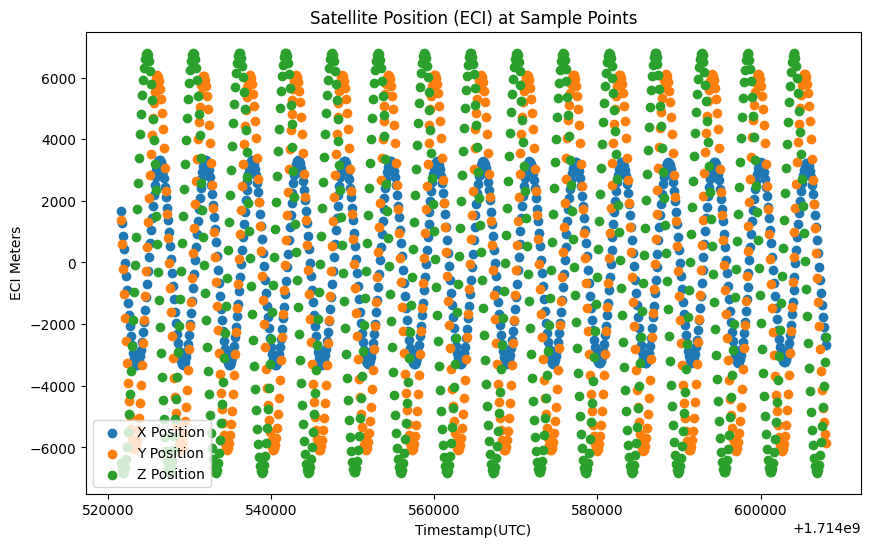

In [150]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set up the plot
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size

# Plot each series
plt.scatter(sample_timestamps, pos_samples[:, 0], label=f'X Position')  # Plot each column and label it
plt.scatter(sample_timestamps, pos_samples[:, 1], label=f'Y Position')  # Plot each column and label it
plt.scatter(sample_timestamps, pos_samples[:, 2], label=f'Z Position')  # Plot each column and label it

# Add legend, labels, and title
plt.legend()
plt.xlabel('Timestamp(UTC)')
plt.ylabel('ECI Meters')
plt.title('Satellite Position (ECI) at Sample Points')

Text(0.5, 1.0, 'Satellite Velocity (ECI) at Sample Points')

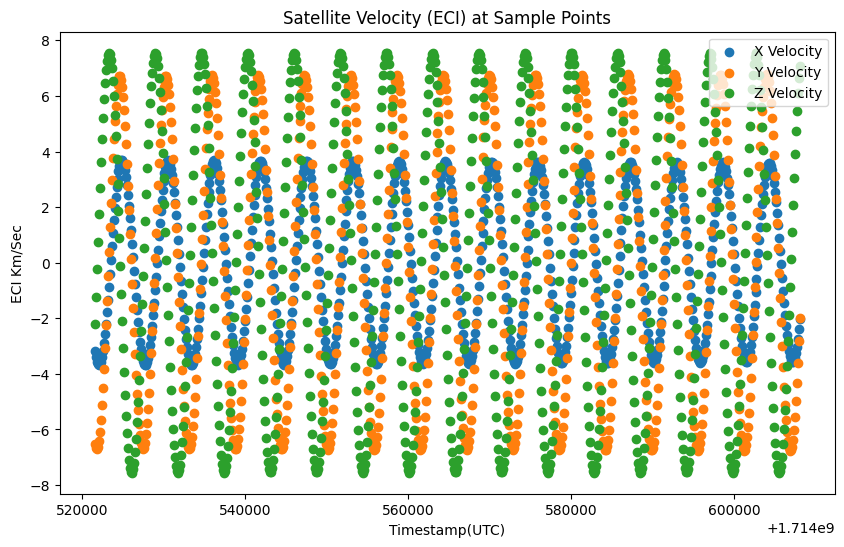

In [151]:
# Set up the plot
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size

# Plot each series
plt.scatter(sample_timestamps, vel_samples[:, 0], label=f'X Velocity')  # Plot each column and label it
plt.scatter(sample_timestamps, vel_samples[:, 1], label=f'Y Velocity')  # Plot each column and label it
plt.scatter(sample_timestamps, vel_samples[:, 2], label=f'Z Velocity')  # Plot each column and label it

# Add legend, labels, and title
plt.legend()
plt.xlabel('Timestamp(UTC)')
plt.ylabel('ECI Km/Sec')
plt.title('Satellite Velocity (ECI) at Sample Points')

In [152]:
from numpy import absolute
from scipy.interpolate import CubicSpline, CubicHermiteSpline, PchipInterpolator, Akima1DInterpolator

def compute_min_max_delta(interpolator, x_timestamps, y_actuals):
    """
    Computes the minimum and maximum delta between actual values and interpolated values.
    
    Args:
    interpolator (scipy.interpolate): The interpolator object (e.g., CubicSpline, CubicHermiteSpline).
    x_timestamps (array-like): The timestamps at which to evaluate the interpolator.
    y_actuals (array-like): The actual position or velocity values at x_timestamps.
    
    Returns:
    tuple: A tuple containing the minimum and maximum deltas for each dimension.
    """
    # Evaluate the interpolator at the given timestamps
    interpolated_values = interpolator(x_timestamps)
    
    # Compute the delta between actual values and interpolated values
    delta = np.abs(y_actuals - interpolated_values)
    
    # Calculate the minimum and maximum delta
    max_delta = np.max(delta, axis=0)

    # Calculate the angular differences
    norms_actual = np.linalg.norm(y_actuals, axis=1)
    norms_interpolated = np.linalg.norm(interpolated_values, axis=1)
    dot_products = np.einsum('ij,ij->i', y_actuals, interpolated_values)
    cos_theta = dot_products / (norms_actual * norms_interpolated)
    
    # Numerical issues might make cos_theta slightly > 1 or < -1, correct those
    cos_theta = np.clip(cos_theta, -1, 1)
    
    # Compute angular differences in radians
    angular_differences = np.arccos(cos_theta)

    absolute_differences = np.abs(norms_actual - norms_interpolated)
    
    # Get the maximum angular difference
    max_angular_difference = np.degrees(np.max(angular_differences))
    max_absolute_difference = np.max(absolute_differences)


    print(f"max delta (m) by components: {max_delta * 1000}")
    print(f"max absolute delta (m): {max_absolute_difference * 1000}")
    print(f"max angular difference (deg): {max_angular_difference}")
    print()

    return max_angular_difference
    

cubic_pos_interp = CubicSpline(sample_timestamps, pos_samples, extrapolate=False)
hermite_pos_interp = CubicHermiteSpline(sample_timestamps, pos_samples, vel_samples, extrapolate=False)

print("Cubic (Pos)")
compute_min_max_delta(cubic_pos_interp, times_1sec_timestamps, pos_1sec)
print("CubicHermite (Pos)")
compute_min_max_delta(hermite_pos_interp, times_1sec_timestamps, pos_1sec)

cubic_vel_interp = CubicSpline(sample_timestamps, vel_samples, extrapolate=False)
pchip_vel_interp = PchipInterpolator(sample_timestamps, vel_samples, extrapolate=False)
akima_vel_interp = Akima1DInterpolator(sample_timestamps, vel_samples)

print("Cubic (Vel)")
compute_min_max_delta(cubic_vel_interp, times_1sec_timestamps, vel_1sec)
print("PCHIP (Vel)")
compute_min_max_delta(pchip_vel_interp, times_1sec_timestamps, vel_1sec)
print("Akima (Vel)")
compute_min_max_delta(akima_vel_interp, times_1sec_timestamps, vel_1sec)


Cubic (Pos)
max delta (m) by components: [20.89584719 48.75309643 58.21735474]
max absolute delta (m): 60.452026119492075
max angular difference (deg): 5.5587155819166294e-05

CubicHermite (Pos)
max delta (m) by components: [2.75067105 5.07881118 5.5260864 ]
max absolute delta (m): 5.720256268432422
max angular difference (deg): 3.1945284701301985e-06

Cubic (Vel)
max delta (m) by components: [0.02876803 0.05588521 0.05768095]
max absolute delta (m): 0.06736609055568721
max angular difference (deg): 7.143693024392837e-05

PCHIP (Vel)
max delta (m) by components: [ 7.71709456 13.89018059 16.65323227]
max absolute delta (m): 16.518234006351662
max angular difference (deg): 0.05418064742927497

Akima (Vel)
max delta (m) by components: [0.5615141  1.03291802 1.13216407]
max absolute delta (m): 0.12967773212668732
max angular difference (deg): 0.008551453874817939



0.008551453874817939

# more checking on cubic spline velocity...

In [153]:
# build 3 hour time windows

total_samples = len(sample_times)
window_size = 60 # 3 hours at 2 minute spacing

max_diff = 0
for start_index in range(total_samples-window_size+1):
    end_index = start_index + window_size

    window_sample_timestamps = sample_timestamps[start_index:end_index]
    window_pos_samples = pos_samples[start_index:end_index]
    window_vel_samples = vel_samples[start_index:end_index]

    cubic_window_vel_interp = CubicSpline(window_sample_timestamps, window_vel_samples)
        # Find indices of 1-second timestamps that fall within the current window
    indices = np.where((np.array(times_1sec_timestamps) >= window_sample_timestamps[0]) & (np.array(times_1sec_timestamps) <= window_sample_timestamps[-1]))[0]
    window_times_1sec = np.array(times_1sec_timestamps)[indices]
    window_vel_1sec = vel_1sec[indices]

    print(f"i={start_index}")
    max_diff = np.fmax(compute_min_max_delta(cubic_window_vel_interp, window_times_1sec, window_vel_1sec), max_diff)

print(f"min diff: {max_diff}")

i=0
max delta (m) by components: [0.02876803 0.05588521 0.05978286]
max absolute delta (m): 0.067669790747793
max angular difference (deg): 7.057976895936414e-05

i=1
max delta (m) by components: [0.02978889 0.05579239 0.06422748]
max absolute delta (m): 0.06835896985180057
max angular difference (deg): 6.78897697964199e-05

i=2
max delta (m) by components: [0.03048992 0.05511164 0.06736615]
max absolute delta (m): 0.06891672597841847
max angular difference (deg): 6.414107696248067e-05

i=3
max delta (m) by components: [0.03087027 0.05383178 0.06902533]
max absolute delta (m): 0.06931109035690497
max angular difference (deg): 5.9623727442754534e-05

i=4
max delta (m) by components: [0.03090392 0.0518997  0.06910569]
max absolute delta (m): 0.06952185906694552
max angular difference (deg): 5.468151935450071e-05

i=5
max delta (m) by components: [0.03054317 0.04923257 0.06759391]
max absolute delta (m): 0.06954199952780016
max angular difference (deg): 4.970986620706738e-05

i=6
max delt